# Nengo Supervised Learning

__Huge__ inspiration was drawn from [this article](https://www.nengo.ai/nengo-loihi/v1.0.0/examples/mnist-convnet.html).

## Import Nengo, NumPy, and TensorFlow

In [1]:
import matplotlib.pyplot as plt
# import nengo, nengo_dl, nengo_loihi
import numpy as np
import tensorflow as tf

## Declare problem

Very simple initial problem. Two bit inputs and an XOR target.

In [2]:
inputs = np.array([[0, 1], [0, 0], [1, 0], [1, 1]])
labels = np.array([1, 0, 1, 0])

## Declare model

The model has two layers. The first layer starts from a `Node`. The problem inputs will be provided to this node from outside the model. This node is directly connected to the neurons of an ensemble. The second connection is between the neurons of this ensemble and the output `Node`. The weights of both connections are initialized with Glorot initialization. The output `Node` can be read from outside the model and thus serves as the model's output.

In [3]:
max_rate = 100  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
presentation_time = 0.1

model = nengo.Network()

with model:
    # set up the default parameters for ensembles/connections
    nengo_loihi.add_params(model)
    model.config[nengo.Ensemble].neuron_type = nengo.SpikingRectifiedLinear(
        amplitude=amp#, initial_state={'voltage': 0},
    )
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None  # finally makes it work
    
    features = nengo.Node(
        nengo.processes.PresentInput(inputs, presentation_time), size_out=2,
    )
    
    # intermediate Ensembles make network perform a lot better
    ens1 = nengo.Ensemble(n_neurons=50, dimensions=1)
    ens2 = nengo.Ensemble(n_neurons=50, dimensions=1)
    conn1 = nengo.Connection(features, ens1.neurons, transform=nengo_dl.dists.Glorot())
    conn2 = nengo.Connection(ens1.neurons, ens2.neurons, transform=nengo_dl.dists.Glorot())
    
    out = nengo.Node(size_in=2)
    conn3 = nengo.Connection(ens2.neurons, out, transform=nengo_dl.dists.Glorot())
    
    out_p = nengo.Probe(out)
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01))

## Train model

Nengo uses the interface from TensorFlow to train a SNN. TensorFlow must have GPU support in order for this training to work. Furthermore, the synapse of each connection needs to be set to None, as otherwise the synaptic delay is too large for the weights to change. The activation of the output `Node` is used to compute a loss that is used to optimize the weights of the two connections.

In [4]:
train_inputs = np.tile(inputs[:, np.newaxis], (100, 1, 1))
train_labels = np.tile(labels[:, np.newaxis, np.newaxis], (100, 1, 1))
test_inputs = np.tile(inputs[:, np.newaxis], (1, 100, 1))
test_labels = np.tile(labels[:, np.newaxis, np.newaxis], (1, 100, 1))

with nengo_dl.Simulator(model, minibatch_size=1) as sim:
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    )
    sim.fit(train_inputs, {out_p: train_labels}, epochs=5)
    
    sim.freeze_params(model)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Epoch 1/5
400/400 [==============================] - 10s 19ms/step - loss: 0.4826 - probe_loss: 0.4826
Epoch 2/5
400/400 [==============================] - 8s 19ms/step - loss: 0.1818 - probe_loss: 0.1818
Epoch 3/5
400/400 [==============================] - 8s 19ms/step - loss: 0.1559 - probe_loss: 0.1559
Epoch 4/5
400/400 [==============================] - 8s 19ms/step - loss: 0.1254 - probe_loss: 0.1254
Epoch 5/5
400/400 [==============================] - 8s 19ms/step - loss: 0.0819 - probe_loss: 0.0819


## Test model

Test the model on the four possible inputs. The actual model is run with a synaptic delay as would be the case on the Loihi chip. The model seems to have trouble with only zero inputs, as it is not clear whether 0 or 1 is preferred in the bottom plot.

In [5]:
def classification_accuracy(y_true, y_pred):
    print(y_true)
    return 100 * tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])

In [6]:
for conn in model.all_connections:
    conn.synapse = 0.005

with nengo_dl.Simulator(model, minibatch_size=1) as sim:
    sim.compile(loss={out_p_filt: classification_accuracy})
    accuracy = sim.evaluate(test_inputs, {out_p_filt: test_labels}, verbose=False)
    print(f'Accuracy with synapse: {accuracy["loss"]:.2f}')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Tensor("IteratorGetNext:2", shape=(1, 100, 1), dtype=int32)                    
Tensor("IteratorGetNext:2", shape=(1, 100, 1), dtype=int32)                    
Accuracy with synapse: 100.00


In [7]:
for ensemble in model.all_ensembles:
    ensemble.neuron_type = nengo.SpikingRectifiedLinear(
        amplitude=amp, initial_state={'voltage': 0},
    )

with nengo_loihi.Simulator(
    model,
    dt=0.001,
    precompute=False,
) as sim:
    # run the simulation on Loihi
    sim.run(0.4)

D:\Users\Niels-laptop\.conda\envs\neuro_comp\lib\site-packages\nengo_loihi\simulator.py:147: UserWarning: Model is precomputable. Setting precompute=False may slow execution.
  warnings.warn(


True labels: [1, 0, 1, 0]


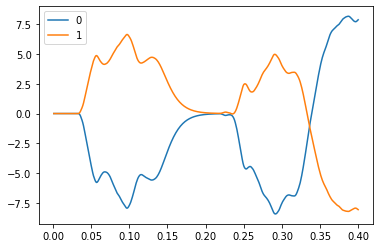

In [8]:
plt.plot(sim.trange(), sim.data[out_p_filt])
plt.legend(['0', '1'], loc="best")
print(f'True labels: {labels.tolist()}')